In [1]:
import json
import pandas as pd
import glob
import os
from itertools import chain
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import export_text, plot_tree
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def get_data_from_dir(exp_dir):
    # get op, int format data from exp_dir
    exps = glob.glob(os.path.join(exp_dir, "*/"))
    chromos = []
    for e in exps:
        seed = e.split("/")[-2]
        with open(os.path.join(e, "outcomes.json"), "r") as f:
            results = json.load(f)
            for fitness, chromo in zip(results["pop_vals"], results["chromos"]):
                c = list(chain.from_iterable(chromo[1]))
                c.append(seed)
                c.append(fitness[1])
                chromos.append(c)
    columns = list(chain.from_iterable([[f"aug{i}", f"op{i}"] for i in range(1, 4)]))
    columns.append("seed")
    columns.append("test acc")
    columns
    df = pd.DataFrame(chromos, columns=columns)
    
    # create data in long format
    ops = set(list(df["aug1"]) + list(df["aug2"]) +  list(df["aug3"]))
    indexes = {op:i for i, op in enumerate(ops)}
    chromos_long = np.zeros([len(chromos), len(ops)+2])
    for i, c in enumerate(chromos):
        for aug, intensity in zip(c[:-2][::2], c[:-2][1::2]):
            chromos_long[i][indexes[aug]] = intensity
            chromos_long[i][-2] = int(c[-2])
            chromos_long[i][-1] = c[-1]
    columns_long = list(ops) + ["seed", "fitness"]
    df_long = pd.DataFrame(chromos_long, columns = columns_long)
    return df, df_long, ops


# exp 1: fit regressors to multiple seeds

LR score:  -0.10152499866110731
DT score:  -0.059084420046155994


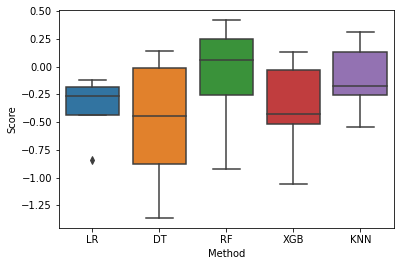

In [12]:
exp_dir = "/home/noah/ESSL/exps/iteration4/exp6_1"
df, df_long, ops = get_data_from_dir(exp_dir)

X = df_long[ops]
y = df_long["fitness"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=10)
reg = LinearRegression().fit(X_train, y_train)
print("LR score: ", reg.score(X_test, y_test))
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)
print("DT score: ", regressor.score(X_test, y_test))

LR = LinearRegression()
lr_scores = cross_val_score(LR, X, y, cv=5)
DT = DecisionTreeRegressor(random_state=0)
dt_scores = cross_val_score(DT, X, y, cv=5)
RF = RandomForestRegressor()
rf_scores = cross_val_score(RF, X, y, cv=5)
XGB = XGBRegressor()
xgb_scores = cross_val_score(XGB, X, y, cv=5)
KNN = KNeighborsRegressor()
knn_scores = cross_val_score(KNN, X, y, cv=5)
long_format = []
long_format+=[["LR", s] for s in lr_scores]
long_format+=[["DT", s] for s in dt_scores]
long_format+=[["RF", s] for s in rf_scores]
long_format+=[["XGB", s] for s in xgb_scores]
long_format+=[["KNN", s] for s in knn_scores]

df = pd.DataFrame(long_format, columns=["Method", "Score"])
sns.boxplot(data=df, x="Method", y="Score")
plt.show()

R-squared value for DT is 0.27 and -0.16 for LR.... Terrible

# exp 2: fit linear regression and DT regressor to dataset with L2 normalization

LR score:  -0.061633052508687
DT score:  0.1318797014263573
|--- Brightness <= 0.55
|   |--- Contrast <= 0.55
|   |   |--- Color <= 0.97
|   |   |   |--- HorizontalFlip <= 0.01
|   |   |   |   |--- Rotate <= -0.29
|   |   |   |   |   |--- Rotate <= -0.53
|   |   |   |   |   |   |--- VerticalFlip <= 0.33
|   |   |   |   |   |   |   |--- value: [82.71]
|   |   |   |   |   |   |--- VerticalFlip >  0.33
|   |   |   |   |   |   |   |--- value: [82.90]
|   |   |   |   |   |--- Rotate >  -0.53
|   |   |   |   |   |   |--- value: [84.24]
|   |   |   |   |--- Rotate >  -0.29
|   |   |   |   |   |--- ShearY <= 0.01
|   |   |   |   |   |   |--- TranslateY <= 0.14
|   |   |   |   |   |   |   |--- ShearX <= 0.10
|   |   |   |   |   |   |   |   |--- TranslateX <= 0.15
|   |   |   |   |   |   |   |   |   |--- VerticalFlip <= 0.88
|   |   |   |   |   |   |   |   |   |   |--- ShearX <= 0.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 10
|   |   |   |   |   |   |   |   |  

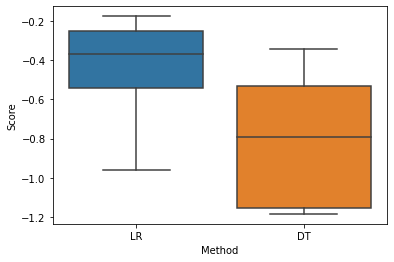

In [5]:
# normalize the data
from sklearn.preprocessing import normalize
X_train = normalize(X_train)
X_test = normalize(X_test)

reg = LinearRegression().fit(X_train, y_train)
print("LR score: ", reg.score(X_test, y_test))
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)
print("DT score: ", regressor.score(X_test, y_test))
regressor.get_depth()
tree = export_text(regressor, feature_names=list(ops))
print(tree)

LR = LinearRegression()
lr_scores = cross_val_score(LR, X, y, cv=5)
DT = DecisionTreeRegressor(random_state=0)
dt_scores = cross_val_score(DT, X, y, cv=5)
long_format = []
long_format+=[["LR", s] for s in lr_scores]
long_format+=[["DT", s] for s in dt_scores]
df = pd.DataFrame(long_format, columns=["Method", "Score"])
sns.boxplot(data=df, x="Method", y="Score")
plt.show()

Performance decreases when using l2 normalization

# exp 3: fit linear regression and DT regressor to dataset with categorical variables

In [6]:
# train with the categorical dataset
# from sklearn.preprocessing import LabelEncoder
# cols = list(chain.from_iterable([[f"aug{i}", f"op{i}"] for i in range(1, 4)]))
# X = df[cols]
# y = df["test acc"]
# for col in [f"aug{i}" for i in range(1, 4)]:
#     le = LabelEncoder()
#     le.fit(X[col])
#     X[col] = le.transform(X[col])
    
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=10)

# X_train = normalize(X_train)
# X_test = normalize(X_test)

# reg = LinearRegression().fit(X_train, y_train)
# print("LR score: ", reg.score(X_test, y_test))
# regressor = DecisionTreeRegressor(random_state=0)
# regressor.fit(X_train, y_train)
# print("DT score: ", regressor.score(X_test, y_test))
# regressor.get_depth()
# tree = export_text(regressor, feature_names=cols)
# print(tree)



Considerably worse performance when using as categorical

# exp 4: fit linear regression and DT regressor to dataset with neutral values

LR score:  -0.10152499866110731
DT score:  -0.059084420046155994
|--- Solarize <= 0.61
|   |--- ShearY <= 0.01
|   |   |--- Rotate <= 14.00
|   |   |   |--- Solarize <= 0.56
|   |   |   |   |--- Solarize <= 0.41
|   |   |   |   |   |--- VerticalFlip <= 0.49
|   |   |   |   |   |   |--- ShearX <= 0.10
|   |   |   |   |   |   |   |--- Contrast <= 1.43
|   |   |   |   |   |   |   |   |--- Color <= 0.22
|   |   |   |   |   |   |   |   |   |--- Sharpness <= 0.61
|   |   |   |   |   |   |   |   |   |   |--- Solarize <= 0.32
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |   |--- Solarize >  0.32
|   |   |   |   |   |   |   |   |   |   |   |--- value: [83.23]
|   |   |   |   |   |   |   |   |   |--- Sharpness >  0.61
|   |   |   |   |   |   |   |   |   |   |--- value: [82.37]
|   |   |   |   |   |   |   |   |--- Color >  0.22
|   |   |   |   |   |   |   |   |   |--- Sharpness <= 0.44
|   |   |   |   |   |   |   |   |   |   |---

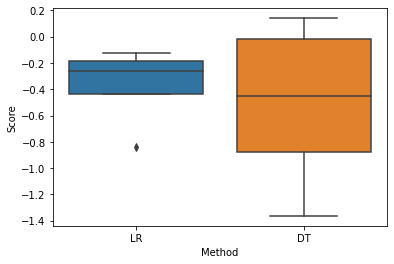

In [7]:
# apply nuetral values to missing values, everything but solarize has value of 0.0 when not applied. 
neutral = {'Brightness':0.0,
 'Color':0.0,
 'Contrast':0.0,
 'HorizontalFlip':0.0,
 'Rotate':0.0,
 'Sharpness':0.0,
 'ShearX':0.0,
 'ShearY':0.0,
 'Solarize':1.0,
 'TranslateX':0.0,
 'TranslateY':0.0,
 'VerticalFlip':0.0
          }

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import export_text, plot_tree

df_long['Solarize'] = df_long['Solarize'].apply(lambda x: 1.0 if x == 0.0 else x)
X = df_long[ops]
y = df_long["fitness"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=10)
reg = LinearRegression().fit(X_train, y_train)
print("LR score: ", reg.score(X_test, y_test))
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)
# print(cross_val_score(regressor, X, y, cv=10))
print("DT score: ", regressor.score(X_test, y_test))
regressor.get_depth()
tree = export_text(regressor, feature_names=list(ops))
print(tree)

LR = LinearRegression()
lr_scores = cross_val_score(LR, X, y, cv=5)
DT = DecisionTreeRegressor(random_state=0)
dt_scores = cross_val_score(DT, X, y, cv=5)
long_format = []
long_format+=[["LR", s] for s in lr_scores]
long_format+=[["DT", s] for s in dt_scores]
df = pd.DataFrame(long_format, columns=["Method", "Score"])
sns.boxplot(data=df, x="Method", y="Score")
plt.show()

We do not see any improvement chanigng solarize to 1 instead of zero... this is expected. 

In [8]:
exp_dir = "/home/noah/ESSL/exps/iteration4/exp6_1"
coeffs = []
exps = glob.glob(os.path.join(exp_dir, "*/"))
# chromos = []
# for e in exps:
#     seed = e.split("/")[-2]
#     with open(os.path.join(e, "outcomes.json"), "r") as f:
#         results = json.load(f)
#         for fitness, chromo in zip(results["pop_vals"], results["chromos"]):
#             c = list(chain.from_iterable(chromo[1]))
#             c.append(seed)
#             c.append(fitness[1])
#             chromos.append(c)
# columns = list(chain.from_iterable([[f"aug{i}", f"op{i}"] for i in range(1, 4)]))
# columns.append("seed")
# columns.append("test acc")
# columns

# df = pd.DataFrame(chromos, columns=columns)
# ops = set(list(df["aug1"]) + list(df["aug2"]) +  list(df["aug3"]))
# indexes = {op:i for i, op in enumerate(ops)}
# chromos_long = np.zeros([len(chromos), len(ops)+2])

# for i, c in enumerate(chromos):
#     for aug, intensity in zip(c[:-2][::2], c[:-2][1::2]):
#         chromos_long[i][indexes[aug]] = intensity
#         chromos_long[i][-2] = int(c[-2])
#         chromos_long[i][-1] = c[-1]

# columns_long = list(ops) + ["seed", "fitness"]
# df_long = pd.DataFrame(chromos_long, columns = columns_long)
# df_long
# ops
# df_long
e = exps[0]
with open(os.path.join(e, "outcomes.json"), "r") as f:
    results = json.load(f)
results

{'pop_vals': [[0, 82.84],
  [0, 82.58],
  [0, 82.7],
  [0, 82.68],
  [0, 82.62],
  [0, 82.93],
  [0, 82.44],
  [0, 82.52],
  [0, 82.91],
  [0, 82.6],
  [0, 82.55],
  [0, 82.36],
  [0, 82.93],
  [0, 83.44],
  [0, 83.4],
  [1, 82.89],
  [1, 83.03],
  [1, 83.37],
  [1, 83.11],
  [1, 82.72],
  [1, 83.22],
  [1, 82.62],
  [1, 81.93],
  [1, 82.48],
  [1, 83.36],
  [1, 81.96],
  [1, 82.5],
  [1, 82.6],
  [1, 83.44],
  [1, 83.4],
  [2, 83.11],
  [2, 82.5],
  [2, 81.96],
  [2, 83.36],
  [2, 82.12],
  [2, 82.4],
  [2, 82.84],
  [2, 81.81],
  [2, 82.71],
  [2, 82.89],
  [2, 83.35],
  [2, 82.76],
  [2, 82.42],
  [2, 83.44],
  [2, 83.4],
  [3, 82.5],
  [3, 83.36],
  [3, 82.52],
  [3, 82.13],
  [3, 81.96],
  [3, 82.84],
  [3, 82.73],
  [3, 82.9],
  [3, 83.21],
  [3, 82.56],
  [3, 82.88],
  [3, 82.93],
  [3, 83.11],
  [3, 83.44],
  [3, 83.4],
  [4, 82.64],
  [4, 82.65],
  [4, 82.19],
  [4, 82.27],
  [4, 82.9],
  [4, 82.64],
  [4, 83.1],
  [4, 81.89],
  [4, 82.67],
  [4, 82.39],
  [4, 82.4],
  [4, 82.

In [9]:
from collections import defaultdict
from sklearn.model_selection import KFold

exps = ["/home/noah/ESSL/cc_experiments/models_figs/opts/xp8_0/previous/runexp8-0", "/home/noah/ESSL/exps/iteration4/exp6_1"]
chromos = defaultdict(list)

for e in glob.glob(os.path.join(exps[0], "*/")):
    seed = e.split("/")[-2]
    with open(os.path.join(e, "outcomes.json"), "r") as f:
        results = json.load(f)
        for fitness, chromo in zip(results["pop_vals"], results["chromos"]):
            c = list(chain.from_iterable(chromo[1]))
            c.append(e_i.split("/")[-1])
            c.append(seed)
            c.append(fitness[1])
            chromos[fitness[0]].append(c)
                
columns = list(chain.from_iterable([[f"aug{i}", f"op{i}"] for i in range(1, 4)]))
columns.append("experiment")
columns.append("seed")
columns.append("test acc")
columns

total_importances = []
indexes = {op:i for i, op in enumerate(ops)}
for gen, pop in chromos.items():
    chromos_long = np.zeros([len(pop), len(ops)+2])
    for i, c in enumerate(pop):
        for aug, intensity in zip(c[:-2][::2], c[:-2][1::2]):
            chromos_long[i][indexes[aug]] = intensity
            chromos_long[i][-2] = int(c[-2])
            chromos_long[i][-1] = c[-1]

    columns_long = list(ops) + ["seed", "fitness"]
    df_long = pd.DataFrame(chromos_long, columns = columns_long)
    X = df_long[ops].to_numpy()
    y = df_long["fitness"].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=10)

    # run kfold again with and get importances for each fold
    kf = KFold(n_splits=5)
    importances = []
    dt_scores = []
    for train, test in kf.split(X):
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
        DT = DecisionTreeRegressor(random_state=0)
        DT.fit(X_train, y_train)
        dt_scores.append(DT.score(X_test, y_test))
        for imp, op in zip(regressor.feature_importances_, ops):
            importances.append([imp, op])
        total_importances+=importances
    importance_df = pd.DataFrame(importances, columns = ["importance", "ops"])
    LR = LinearRegression()
    lr_scores = cross_val_score(LR, X, y, cv=5)
    long_format = []
    long_format+=[["LR", s] for s in lr_scores]
    long_format+=[["DT", s] for s in dt_scores]
    df = pd.DataFrame(long_format, columns=["Method", "Score"])
    sns.boxplot(data=df, x="Method", y="Score")
    plt.suptitle(f"CV on Generation {gen}")
    plt.show()
    plt.clf()
    
    sns.barplot(data = importance_df, x = "ops", y = "importance")
    plt.xticks(rotation=90)
    plt.suptitle(f"DT Feature Importance, Gen {gen}")
    plt.show()
    plt.clf()
total_importance_df = pd.DataFrame(total_importances, columns = ["importance", "ops"])
sns.barplot(data = total_importance_df, x = "ops", y = "importance")
plt.xticks(rotation=90)
plt.suptitle(f"DT Feature Importance, All Gens")
plt.show()
plt.clf()

NameError: name 'e_i' is not defined